# Data-driven selection of constitutive models via Rheology-informed Neural Networks (RhINNs)

This implementation is based on `tensorflow` 2.7.0.
You can find documentation for this Jupyter Notebook on GitHub: https://github.com/MilowSa/RhINNs/tree/main/Model_selection_RhINN

If you have any questions/inquiries about this project, or if you wanted to brainstorm some research/professional ideas, feel free to shoot me an email: saadat.m@northeastern.edu

## Packages

In [7]:
#%% Importing necessary stuff
import tensorflow as tf
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import tensorflow_probability as tfp
import scipy.optimize
from tensorflow import keras
import math
print('tf.__version__:',tf.__version__)

tf.__version__: 2.7.0


## Turning off GPU cores
As other people suggested, running on GPU cores is not actually helping the computation speed: https://developer.apple.com/forums/thread/698901

In this cell, I turn off GPU cores are run the program on CPU cores only.

Hope `tensorflow-metal` gets faster in the future.

In [8]:
#Since running on GPU was actually slower on my machine, I turn down GPU cores in this cell.
#You may comment/unomment this cell to see if the performance changes on your machine or not.

os.environ['TF_DISABLE_MLC'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

tf.config.get_visible_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## General problem information
As is mentioned on the GitHub repo, this code tries to find the best steady-state shear stress vs. shear rate constitutive model from a library of nine (9) constitutive models. The following parameters are required to build the architecture prior to work with the actual data.

In [9]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
tf.random.set_seed(42)

log10 = tf.experimental.numpy.log10 #If you're as lazy as I am

num_models = 9 #Number of constitutive models
num_params = 31 #Number of parameters in the constitutive models
input_dim = 1 #Input (shear rate [s**-1]) dimension
output_dim = 1 #Output (shear stress [Pa]) dimension

## Keras instantiation
A `tf.keras.Model` is instantiated and the architecture is modified to make a stack of layers connected for each constitutive model and disconnected between each constitutive model.

In [10]:
# Define model architecture
#A tf.keras.Model is instantiated here 
class RhINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
            output_dim=1,
            num_hidden_layers=4, 
            num_neurons_per_layer=25,
            num_models = num_models,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)
        self.lb = lb
        self.ub = ub
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons_per_layer = num_neurons_per_layer
        self.num_models = num_models
        # In the next line, a stack of num_models x num_hidden_layers are defined
        #All layers for each constitutive model are fully connected, while layers in each constitutive model
        #do not share information with layers in other constitutive models.
        self.lays = [[tf.keras.layers.Dense(num_neurons_per_layer,
                                           activation=tf.keras.activations.get(activation),
                                           kernel_initializer=kernel_initializer) 
                                           for j in range(self.num_hidden_layers)] for k in range(self.num_models)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.normalize = tf.keras.layers.Normalization(axis=-1)
        
        # Define NN architecture
    def call(self, X):
        """Forward-pass through neural network."""
        def arch_builder(X, i):
            for j in range(self.num_hidden_layers):
                X = self.lays[i][j](X)
            return X
        dump = [self.out(arch_builder(X, i)) for i in range(self.num_models)]
        return dump

#%% RhINN Solver
class RhINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        # Store collocation points
        self.x = X_r
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.histD = []
        self.iter = 0
    
    def get_r(self):
        u = self.model(self.x)
        return self.fun_r(self.x, u)
    
    def loss_fn(self, X, u):
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reshape(tf.reduce_mean(tf.square(r), 1), (1,-1))[0]
        
        # Initialize loss
        loss = phi_r
        
        # Add phi_0 and phi_b to the loss
        for j in range(num_models):
            u_pred = self.model(X[0])
            loss += tf.reduce_mean(tf.square(u - u_pred[j]))
        return loss
    
    def get_grad(self, X, u):
        with tf.GradientTape(persistent=False) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.
                                          model.trainable_variables))
            return loss
        
        for i in range(N):
            loss = train_step()
            self.current_loss = loss
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is no longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list
        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)
            
            # Store current loss for callback function 
            loss = loss.numpy().astype(np.float64)
#             loss_HB = loss_HB.numpy().astype(np.float64)

            self.current_loss = loss           
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None): # Will be overridden
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1

In [11]:
class RhINNInverseModel(RhINN):
    def __init__(self, *args, **kwargs):
        # Call init of base class
        super().__init__(*args,**kwargs)
        # Initialize variable for lambda, the tensor that contains those 31 model parameters
        #A noise is added to the initial condition to break the symmetry
        noise = tf.random.uniform(shape=[num_params], minval = -.05, maxval=.05, dtype=DTYPE, seed=42)
        #Those 31 parameters are initialized to unity
        self.lambd = tf.Variable(1.*tf.ones(num_params)+noise, trainable=True, dtype=DTYPE)
        self.lambd_list = []

class RhINNInverse(RhINNSolver):
    def fun_r(self, x, u):
        """Residual of the PDEs"""
        def model_lib(i):
            m = tf.constant(1e6, dtype = DTYPE) #Yield threshold parameter for Bingham
            #Some of the parameters are inversed (or put inside abs) to ensure stability.
            if i == 0: #Power Law
                p = 2
                eta0, n = [self.model.lambd[j] for j in range(0, 2)]
                res = u[i] - (log10(eta0) + n*log10(X_r))
                return res
            elif i == 1: #Herschel Bulkley
                p = 3
                eta0, n, sigma_y = [self.model.lambd[j] for j in range(2, 5)]
                res = u[i] - log10(eta0*X_r**n+sigma_y)
                return res
            elif i ==2: #Bingham               
                p = 2
                eta0, sigma_y = [self.model.lambd[j] for j in range(5, 7)]
                res = u[i] -log10((eta0*X_r+sigma_y)*(1-tf.exp(-m*X_r)))
                return res
            elif i == 3: #Carreau-Yasuda
                p = 5
                eta0, n, etainf, Lambda, a = [self.model.lambd[j] for j in range(7, 12)]
                res = u[i] - log10(X_r*(etainf+(1/eta0-etainf)*(1+(X_r/Lambda)**a)**((-n-1)/a)))
                return res
            elif i == 4: #TC
                p = 3
                eta0, gamma_dot_c_inv, sigma_y = [self.model.lambd[j] for j in range(12, 15)]
                res = u[i] - log10(sigma_y*(1+tf.math.sqrt(tf.math.abs(X_r*gamma_dot_c_inv))) + eta0*X_r)
                return res
            elif i == 5: #TCC
                p = 4
                gamma_dot_c_inv, gamma_dot_ca_inv, sigma_y, k = [self.model.lambd[j] for j in range(15, 19)]
                res = u[i] - log10(sigma_y*(1 + (tf.math.abs(X_r*gamma_dot_c_inv))**0.5) + (X_r*k)*(1+(X_r*gamma_dot_ca_inv)**2)**(-0.5))
                return res
            elif i == 6: #Casson
                p = 2
                eta0, sigma_y = [self.model.lambd[j] for j in range(19, 21)]
                res = u[i] - 2*log10(tf.sqrt(tf.math.abs(sigma_y)) + tf.sqrt(tf.math.abs(eta0)*X_r))
                return res
            elif i == 7: #TVP
                p = 5
                eta_s, eta_p, sigma_y, kplus, kminus = [self.model.lambd[j] for j in range(21, 26)]
                lambda0 = kplus/(kplus+kminus*X_r)
                res = u[i] - log10(sigma_y*lambda0 +eta_s*X_r + eta_p*lambda0*X_r)
                return res
            elif i == 8: #Steady-state IKH
                p = 5
                eta_p, cq, k1, k2, k3 = [self.model.lambd[j] for j in range(26, 31)]
                res = u[i] - log10(eta_p*X_r + cq +(k1*k3)/(k1+X_r*k2))
                return res
        return [model_lib(i) for i in range(num_models)]

    def callback(self, xr = None):        
        if self.iter % 1000 == 0:
            print('It: {:05d}, loss = {}'.format(self.iter, np.round(self.current_loss,4)))
        
        for items in self.current_loss:
            #A simple for loop to find out which of those nine models is actually making a NaN.
            if math.isnan(items):
                print('NaN. It: {:05d}\nloss = {}.'.format(self.iter, np.round(self.current_loss,4)))
                nan = np.argwhere(np.isnan(Selector.current_loss.numpy()))[0][0]
                tf.print('{} is diverging.'.format(list(labels.values())[nan]))
                sys.exit()

        self.hist.append(self.current_loss)
        self.iter += 1

## Data, baby, data

You may switch between each datasets by changing the `i` parameter.
We passed a `log10` function onto the shear stress, because otherwise, the neural net will only learn the pattern at high shear rates. This is a common practice in rheology since we are dealing with data that span over several orders of magnitude.

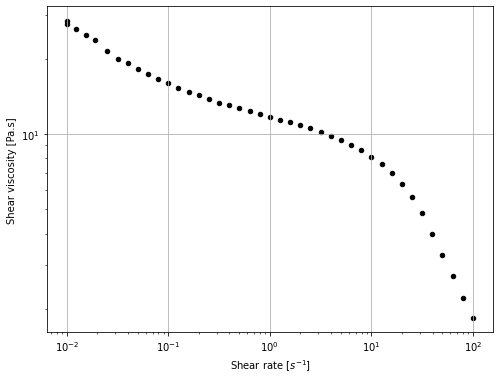

In [15]:
# This cell fetches the data from an excel file and prepares the data to be fed into the network
path = os.getcwd()
files = os.listdir(path)
df = {}
xlsx = pd.ExcelFile('ExpData.xlsx')
df = pd.read_excel(xlsx, sheet_name=None)
data = [[k,v] for k,v in df.items()] #k is the sheet name, v is the pandas df

i = 7 #select between 0 and 12, each is one set of stress vs. shear rate data.

X, y = data[i][1]['ShearRate'], data[i][1]['ShearStress']
#The output (shear stress) is scaled by passing a log10 function onto the initial shear stress values
#Otherwise, the algorithm will only fit to high shear rate datapoints
y = np.log10(y)

#The following scale factor, kk, is used to normalize the log10(y) around zero, nothing too crazy.
kk = float((log10(np.max(10**y))+log10(np.min(10**y)))/2)
# kk = 0.
y = y - kk

X = tf.reshape(tf.convert_to_tensor(X, dtype=DTYPE), (-1,1))
y = tf.reshape(tf.convert_to_tensor(y, dtype=DTYPE), (-1,1))
X_data, u_data = [X], [y]
X_param = X_data
u_param = u_data

labels = {'PL': 'Power law',
          'HB': 'Herschel-Bulkley',
          'BH': 'Bingham',
         'CY': 'Carreau-Yasuda',
         'TC': 'Three-component',
         'TCC': 'TCC',
         'Casson': 'Casson',
         'TVP': 'TVP',
         'IKH': 'Steady-state IKH'}

#Function points
Nf = 401
X_r = np.logspace(np.log10(min(X)), np.log10(max(X)), Nf).reshape(-1,1)
X_r = tf.convert_to_tensor(X_r, dtype=DTYPE)
lb = tf.constant(min(X_r), dtype=DTYPE)
ub = tf.constant(max(X_r), dtype=DTYPE)

#How the data looks like
from matplotlib.pyplot import figure

figure(figsize=(8, 6))
plt.scatter(X,10**(y+kk)/X, color='k', s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Shear rate [$s^{-1}$]')
plt.ylabel('Shear viscosity [Pa.s]')
plt.grid()
plt.show()


## Model initialization

A model is actually built here. For the activation function, `ReLU` was also tested and not much difference was seen. `tanh` in this case provides better stability because of the `log10` scaling that we mentioned above.

In [16]:
#%% Initialize model
model = RhINNInverseModel(lb, ub,
                              output_dim = output_dim,
                              num_hidden_layers=4,
                              num_neurons_per_layer=25,
                              num_models = num_models,
                              activation='tanh',
                              kernel_initializer='glorot_normal')

model.build(input_shape=(None,input_dim))
# Initilize solver
Selector = RhINNInverse(model, X_r)

# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,10000],[1e-3,1e-4,1e-4])

## Adam optimizer

This is where we train the model.

In [17]:
#%% Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time()
iternum = 40001

Selector.solve_with_TFoptimizer(optim, X_param, u_param, N=iternum)

# Print computation time
runtime = np.round(time()-t0,2)
print('\nAdam computation time: {} seconds'.format(runtime))

It: 00000, loss = [8.6022 7.9825 8.9322 8.923  7.9623 7.8754 9.951  8.0872 8.245 ]
It: 01000, loss = [0.1143 0.3096 0.2912 0.1575 0.3388 0.3989 0.4119 0.2945 0.4552]
It: 02000, loss = [0.0563 0.2338 0.2159 0.0864 0.2527 0.3202 0.3186 0.2166 0.3624]
It: 03000, loss = [0.0346 0.1854 0.1676 0.0536 0.1982 0.2624 0.2515 0.1676 0.296 ]
It: 04000, loss = [0.0238 0.1441 0.1261 0.0339 0.1531 0.2007 0.1937 0.1262 0.2345]
It: 05000, loss = [0.0172 0.1044 0.087  0.0224 0.1106 0.1243 0.1422 0.0879 0.171 ]
It: 06000, loss = [0.0125 0.0653 0.0528 0.016  0.0706 0.0453 0.0961 0.0531 0.104 ]
It: 07000, loss = [0.0095 0.0305 0.0352 0.0119 0.0405 0.0065 0.0527 0.0277 0.0308]
It: 08000, loss = [0.0088 0.0123 0.0334 0.0101 0.0324 0.0038 0.0301 0.0219 0.0295]
It: 09000, loss = [0.0085 0.0089 0.0331 0.0088 0.0316 0.0034 0.0259 0.0193 0.0291]
It: 10000, loss = [0.0084 0.008  0.0329 0.0078 0.0314 0.0032 0.0241 0.0169 0.0288]
It: 11000, loss = [0.0082 0.0078 0.0328 0.007  0.0311 0.0031 0.0235 0.0147 0.0287]
It: 

## L-BFGS optimization (optional)

This cell will perform L-BFGS optimization on the trained [and flattened] variables of Adam. 

In [38]:
#%% Solve with L-BFGS optimizer, optional
t0 = time()
Selector.solve_with_ScipyOptimizer(X_data, u_data,
                            method='L-BFGS-B',
                            options={'maxiter': 500,
                                     'maxfun': 500,
                                     'maxcor': 500,
                                     'maxls': 500,
                                     'ftol': 1.0*np.finfo(float).eps,
                                     'gtol' : 1.0*np.finfo(float).eps})
print('\nL-BFGS computation time: {} seconds'.format(time()-t0))


L-BFGS computation time: 1.5941400527954102 seconds


## Recovered parameters

In [18]:
np.array(model.lambd)

array([ 1.4665264e+00,  7.7992082e-01,  1.5436631e+00,  7.5522709e-01,
       -1.5402257e-02,  1.0776571e+00,  5.6093302e-02,  2.1913609e-01,
       -8.0852711e-01, -2.0824280e+00,  3.5012116e+00,  1.9999959e-01,
        9.9372566e-01,  3.3693547e+00,  4.8775934e-02,  3.7731688e+00,
        6.8047993e-02,  2.7775347e-02,  1.5391675e+00,  8.7179935e-01,
        2.2446115e-02, -2.1633433e-02,  1.7995145e+00,  2.8605107e-02,
        1.5104344e+00,  8.2405075e-02,  9.9298024e-01,  1.1118621e-01,
       -1.0284858e-03,  1.7664593e+00,  1.5603518e+00], dtype=float32)

## The best and worst constitutive models

In [19]:
#To see which models are the best and the worst
ls_corr = labels.copy()
ls_corr['Exact'] = 'Exact'
ls = ls_corr.copy()
ls['X'] = 'ShearRate'

best = np.argmin(Selector.hist[-1])
beststr = '{} is the best model.'.format(list(labels.values())[best])
print(beststr)
worst = np.argmax(Selector.hist[-1])
worststr = '{} is the worst model.'.format(list(labels.values())[worst])
print(worststr)

TVP is the best model.
Bingham is the worst model.


## Let's see it

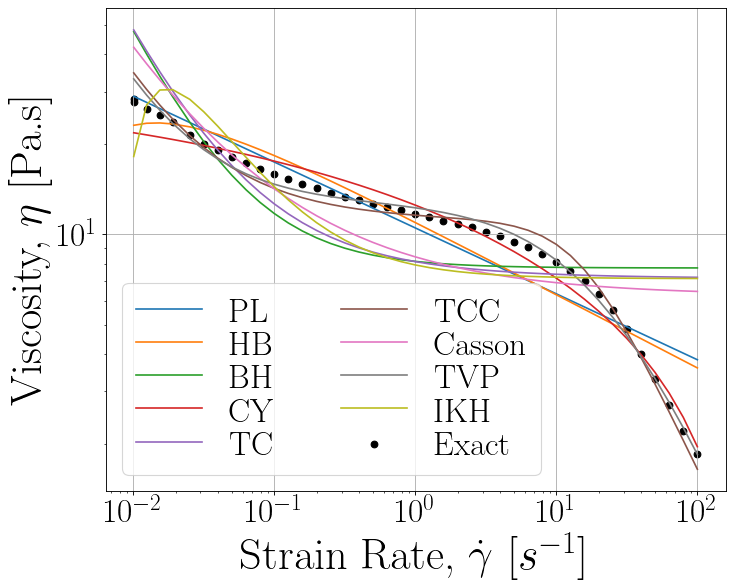

In [20]:
#A very dirty cell to plot the shear viscosity vs. shear rate

m = tf.constant(1e6, dtype = DTYPE) #Yield threshold parameter 
from matplotlib import pyplot
P = model.lambd
X, y = data[i][1]['ShearRate'], data[i][1]['ShearStress']
outs = np.zeros((len(X),num_models+2))

#Constitutive models' behvaior based on the recovered parameters (P)
PL = P[0]*X**P[1]
HB = P[2]*X**P[3]+P[4]
BH = (P[5]*X+P[6])*(1-tf.exp(-m*X))
CY = X*((1/P[7]-P[9])*(1+(X/P[10])**P[11])**((-P[8]-1)/P[11])+P[9])
TC = P[14] + P[14]*(X*tf.math.abs(P[13]))**0.5+P[12]*X
TCC = P[17]+P[17]*(X*tf.math.abs(P[15]))**0.5+X*P[18]*(1+(X*P[16])**2)**(-0.5)
Casson = (tf.math.abs(P[20])**0.5+(tf.math.abs(P[19])*X)**0.5)**2
lambda0 = P[24]/(P[24]+P[25]*X)
TVP = P[23]*lambda0+P[21]*X+P[22]*lambda0*X
IKH = P[26]*X + P[27] + (P[28]*P[30])/(P[28]+X*P[29])

#Reshaping
outs[:,0]=np.reshape((10**kk*PL),(-1,))
outs[:,1]=np.reshape((10**kk*HB),(-1,))
outs[:,2]=np.reshape((10**kk*BH),(-1,))
outs[:,3]=np.reshape((10**kk*CY),(-1,))
outs[:,4]=np.reshape((10**kk*TC),(-1,))
outs[:,5]=np.reshape((10**kk*TCC),(-1,))
outs[:,6]=np.reshape((10**kk*Casson),(-1,))
outs[:,7]=np.reshape((10**kk*TVP),(-1,))
outs[:,8]=np.reshape((10**kk*IKH),(-1,))
outs[:,9]=np.reshape(y,(-1,))
outs[:,10]=np.reshape(X,(-1,))

#The actual plotting
import matplotlib.font_manager
from matplotlib import rc
rc('font', **{'family': 'Times New Roman', 'serif': ['Computer Modern']})
rc('text', usetex=True)
colors = ['tab:blue','tab:orange','tab:green',
          'tab:red','tab:purple','tab:brown','tab:pink','tab:gray',
          'tab:olive','tab:cyan','gold', 'lightcoral', 'k']

plt.figure(figsize=(10,8),dpi=80)

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

for items in range(num_models):
    
    plt.plot(outs[:,-1],outs[:,items]/outs[:,-1], label=list(labels)[items], color=list(colors)[items])

plt.scatter(outs[:,-1], outs[:,-2]/outs[:,-1], label='Exact', color='k')

plt.legend(ncol=2, handleheight=1., labelspacing=0.01, loc='best', fontsize=30)
plt.xlabel('Strain Rate, $\dot{\gamma}$ [$s^{-1}$]', fontname = 'Times New Roman', fontsize=40)
plt.ylabel('Viscosity, $\eta$ [Pa.s]', fontname = 'Times New Roman', fontsize=40)
plt.xticks(fontname = "Times New Roman", fontsize=30)
plt.yticks(fontname = "Times New Roman", fontsize=30)
plt.xscale('log')
plt.yscale('log')
plt.grid()
# plt.savefig('Model prediction for '+str(data[i][0]), bbox_inches='tight', dpi=300)

plt.show()